### Inundation Risk Modelling With HAND Model using `PySheds`
This notebook demonstrates flood risk assessment using the Height Above Nearest Drainage (HAND) model. By using Digital Elevation Models (DEMs) and calculating the vertical distance of terrain points from the drainage network, the HAND model helps classify areas based on their flood risk potential. The workflow is implemented with Python libraries such as rasterio, numpy, Pysheds, and matplotlib. The notebook covers data preparation, HAND calculation, and flood risk classification with clear, reproducible steps.

With consideration of rainfall and terrain involves leveraging the library’s capabilities for flow direction, flow accumulation, and watershed delineation from a Digital Elevation Model (DEM). Here’s a step-by-step guide:

Reference:
https://mattbartos.com/pysheds/hand.html

Pysheds, https://mattbartos.com/pysheds/

#### Conducting flooding vulnerability analysis using PySheds
with consideration of rainfall and terrain involves leveraging the library’s capabilities for flow direction, flow accumulation, and watershed delineation from a Digital Elevation Model (DEM). Here’s a step-by-step guide:

##### 1. Prepare the required module
We need to install them first. If you have them install, just comment these statements and continue

In [3]:
!pip install pysheds
!pip install seaborn

  Using cached pysheds-0.4.tar.gz (91 kB)
  Preparing metadata (setup.py) ... done
  Using cached looseversion-1.3.0-py2.py3-none-any.whl.metadata (4.6 kB)
  Using cached numba-0.61.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (2.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 22.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 21.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 22.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 14.3 MB/s eta 0:00:00
  Created wheel for pysheds: filename=pysheds-0.4-py3-none-any.whl size=90690 sha256=34421d4468cbeb887b6f6c1cc1f82b6f34df2ee1f3f0a4f9e82b499e4f9e0986
  Stored in directory: /Users/songj/Library/Caches/pip/wheels/8f/2b/0d/988f11a32332312c4d5dfe1720f891789e5b01853f6a842be6
Successfully built pysheds
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import numpy as np
import pysheds
from pysheds.grid import Grid

#### 2. Computing the height above nearest drainage


##### 2.1 computing the flow directions and accumulation for a given DEM
You can download the DEM file from [here](https://utilitiesfiles.s3.us-east-1.amazonaws.com/ai-sustainability/dem.tiff)



In [ ]:
# Instantiate grid from raster
grid = Grid.from_raster('dem.tiff')
dem = grid.read_raster('dem.tiff')

# # Resolve flats and compute flow directions
# inflated_dem = grid.resolve_flats(dem)
# fdir = grid.flowdir(inflated_dem)

# # Compute accumulation
# acc = grid.accumulation(fdir)


RasterioIOError: dem.tiff: No such file or directory

In [ ]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)

# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

In [ ]:
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    
# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

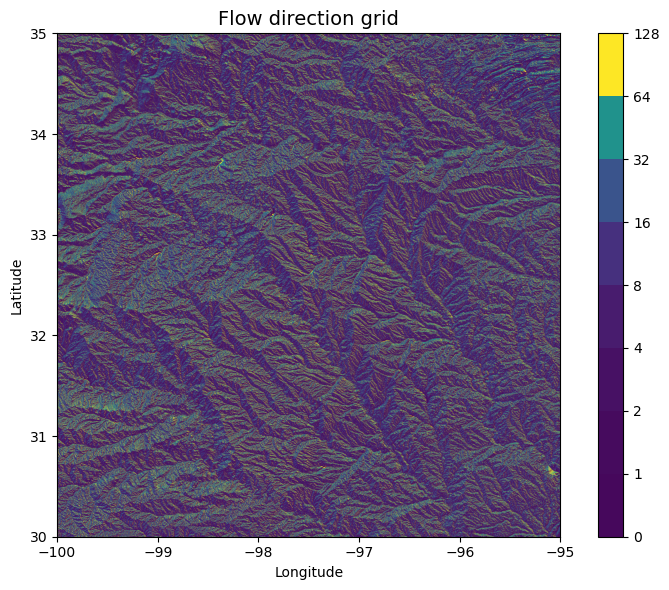

In [ ]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

#### Compute accumulation from flow direction


In [ ]:
# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

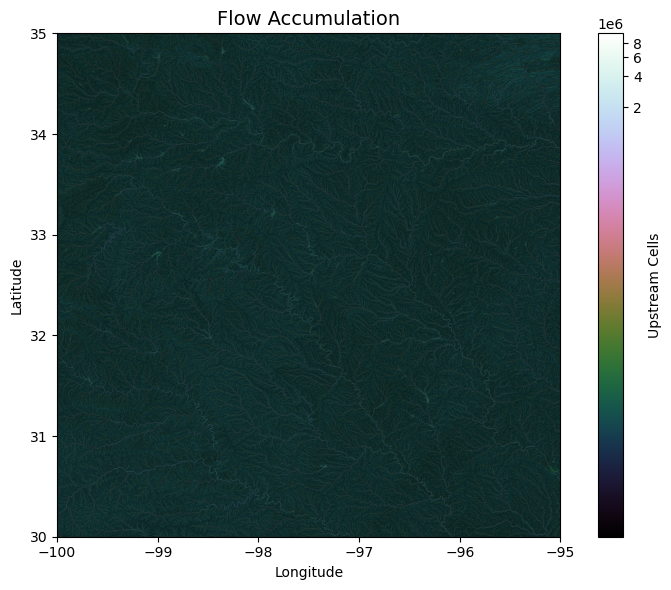

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.PowerNorm(gamma=0.1, vmin=acc.min(), vmax=acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

##### 2.2 Compute the height above nearest drainage
We can then compute the height above nearest drainage (HAND) by providing a DEM, a flow direction grid, and a channel mask. For this demonstration, we will take the channel mask to be all cells with accumulation greater than 200.



In [ ]:

# Compute height above nearest drainage
hand = grid.compute_hand(fdir, dem, acc > 200)


##### 2.3 Check the calculated HAND results

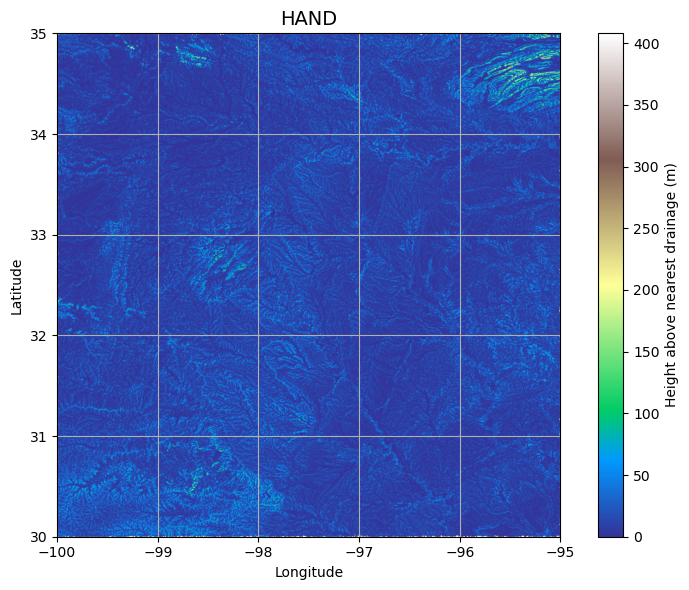

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.imshow(hand, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Height above nearest drainage (m)')
plt.grid(zorder=0)
plt.title('HAND', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

The whole area is too big, we will clip the HAND raster to a catchment to make it easier to work with.


In [ ]:
# Specify outlet
x, y = -97.294167, 32.73750

# Delineate a catchment
catch = grid.catchment(x=x, y=y, fdir=fdir, xytype='coordinate')

# # Clip to the catchment
grid.clip_to(catch)

# Create a view of HAND in the catchment
hand_view = grid.view(hand, nodata=np.nan)

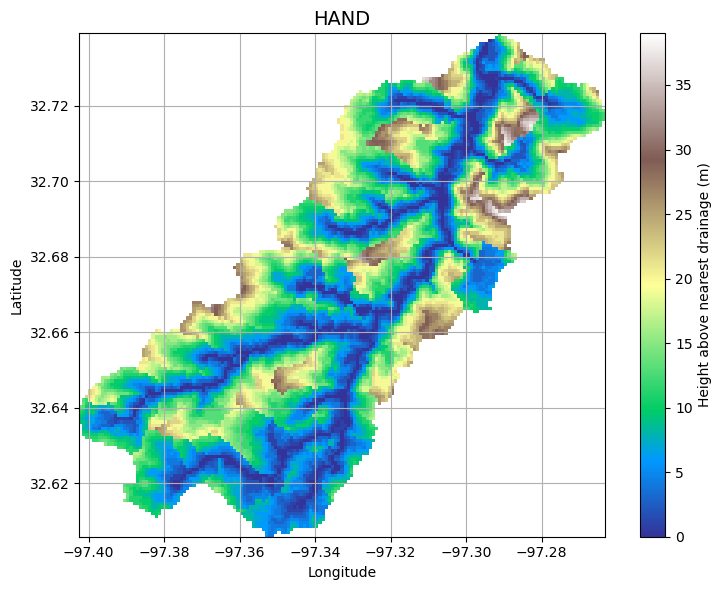

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.imshow(hand_view, 
           extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Height above nearest drainage (m)')
plt.grid(zorder=0)
plt.title('HAND', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

#### Estimating inundation extent (constant channel depth)
We can estimate the inundation extent (assuming a constant channel depth) using a simple binary threshold:

Explanation of the function `numpy.where(condition, x, y)`, 

condition: A boolean condition that is evaluated on the array.
x (optional): Values to select when the condition is True.
y (optional): Values to select when the condition is False.

In [ ]:
threshold = 3

#if the hand value is larger than threshold, then use nan
inundation_extent = np.where(hand_view < threshold, threshold - hand_view, np.nan) 


Let's plot the inudation area

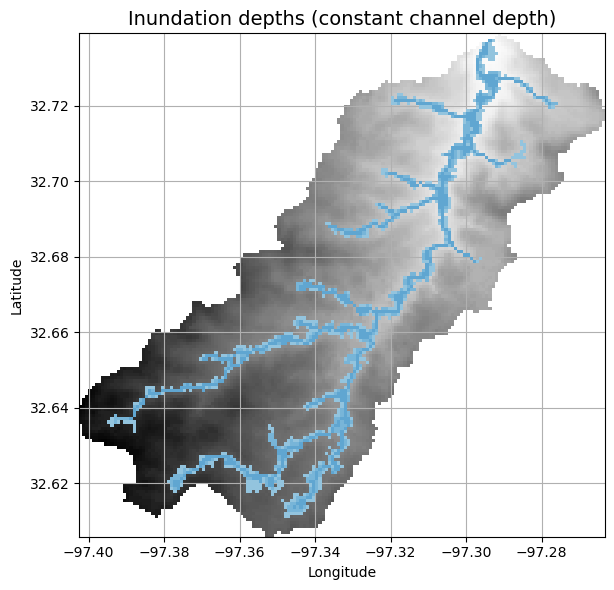

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
dem_view = grid.view(dem, nodata=np.nan)
plt.imshow(dem_view, extent=grid.extent, cmap='Greys', zorder=1)
plt.imshow(inundation_extent, extent=grid.extent,
           cmap='Blues', vmin=-5, vmax=10, zorder=2)
plt.grid(zorder=0)
plt.title('Inundation depths (constant channel depth)', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

#### Export the generated results into a geotiff

In [ ]:
import rasterio as rio

datasource = rio.open('dem.tiff')
meta = datasource.meta

# Update metadata if needed (e.g., change datatype, compression, etc.)
meta.update(dtype=rio.float32, compress='lzw', nodata=np.nan)

# Write the output GeoTIFF
with rio.open('out_res.tif', 'w', **meta) as dst:
    dst.write(hand, 1)


### Homework 
#### Please download DEM in Pennsylvania and run the HAND model

- Please download the DEM tiles for Pennsylvania
- Run the HAND model to estimate the inudation depth for each tile
- Export the results to geotiff
- Mosaic the exposed results into a complete `geotiff` for whole Pennsylvania.
- Upload your notebook and submit a report to present your map for PA. 

Here is a hint about how to conduct the analysis for one tile. You can reference this for your homework. You need to generate the results for whole Pennsylvania. You will need to use loop to download DEM tiles for Pennsylvania, and conduct the mosaicing to generate the image for the whole state. 

Use the download-dem.ipynb to download the dem data for any location. 


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
import pysheds
import numpy as np


#### Detecting pits

Detecting pits (depressions or sinks) in a Digital Elevation Model (DEM) is an essential step in hydrological analysis. Pits are areas where water cannot flow out because they are surrounded by higher terrain. Detecting and handling pits ensures accurate flow direction and accumulation computations.

Pits can be detected using the `grid.detect_depressions` method:

In [ ]:
demfile = 'USGS_1_n41w076_20221115.tif'

# Read raw DEM
grid = Grid.from_raster(demfile)
dem = grid.read_raster(demfile)

# Detect pits
pits = grid.detect_pits(dem)

In [ ]:
grid.crs

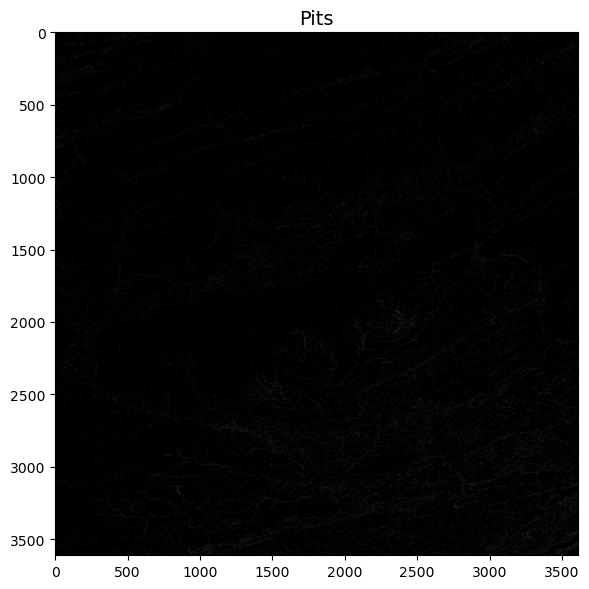

In [ ]:
# Plot pits
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(pits, cmap='Greys_r', zorder=1)
plt.title('Pits', size=14)
plt.tight_layout()

#### Filling pits
Pits can be filled using the `grid.fill_pits` method:


In [ ]:
# Fill pits
pit_filled_dem = grid.fill_pits(dem)
pits = grid.detect_pits(pit_filled_dem)
assert not pits.any()

#### Detecting depressions
Depressions can be detected using the `grid.detect_depressions` method:


In [ ]:
# Detect depressions
depressions = grid.detect_depressions(pit_filled_dem)

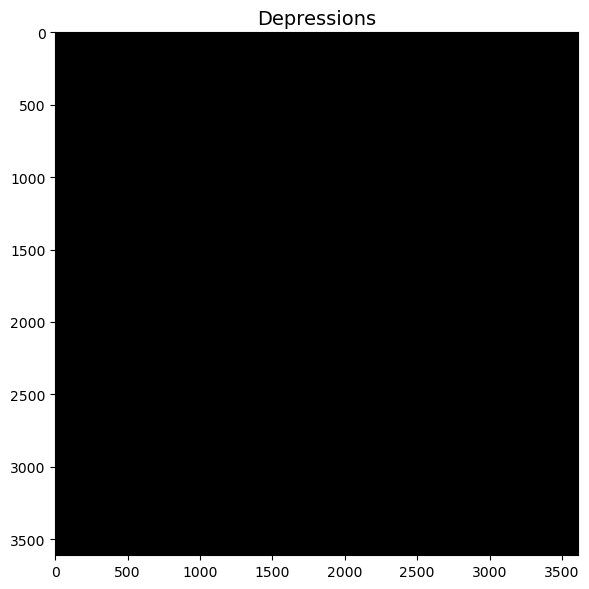

In [ ]:
# Plot depressions
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(depressions, cmap='Greys_r', zorder=1)
plt.title('Depressions', size=14)
plt.tight_layout()


#### Filling depressions
Depressions can be filled using the `grid.fill_depressions` method:


In [ ]:
# Fill depressions
flooded_dem = grid.fill_depressions(pit_filled_dem)
depressions = grid.detect_depressions(flooded_dem)
assert not depressions.any()

#### Resolving flats
Flats can be resolved using the `grid.resolve_flats` method:


In [ ]:
inflated_dem = grid.resolve_flats(flooded_dem)
flats = grid.detect_flats(inflated_dem)
# assert not flats.any()

#### Computing accumulation
After filling depressions and resolving flats, the flow direction can be determined as usual. Accumulation is computed using the grid.accumulation method.

In [ ]:
# Compute flow direction based on corrected DEM
fdir = grid.flowdir(inflated_dem)

# Compute flow accumulation based on computed flow direction
acc = grid.accumulation(fdir)

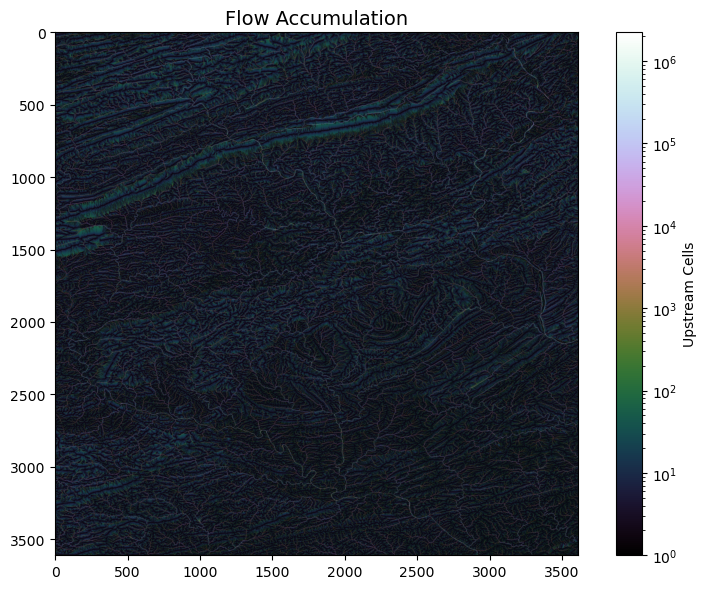

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
im = ax.imshow(acc, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.tight_layout()

In [ ]:
# Compute height above nearest drainage
hand = grid.compute_hand(fdir, dem, acc > 200)

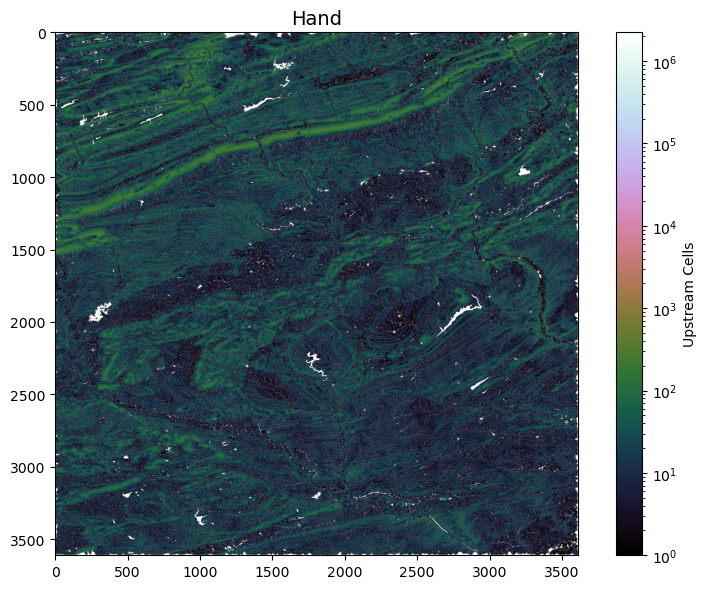

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
im = ax.imshow(hand, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Hand', size=14)
plt.tight_layout()

#### Estimating inundation extent (constant channel depth)


In [ ]:
threshold = 5
inundation_extent = np.where(hand < threshold, threshold - hand, np.nan)

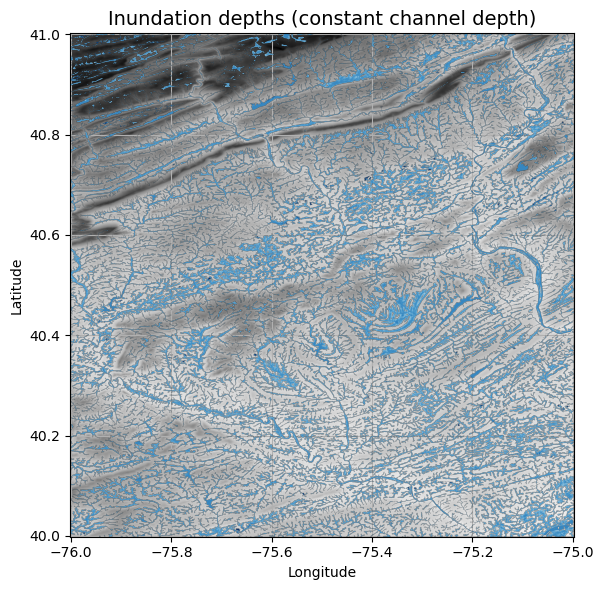

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
dem_view = grid.view(dem, nodata=np.nan)
plt.imshow(dem_view, extent=grid.extent, cmap='Greys', zorder=1)
plt.imshow(inundation_extent, extent=grid.extent,
           cmap='Blues', vmin=-5, vmax=10, zorder=2)
plt.grid(zorder=0)
plt.title('Inundation depths (constant channel depth)', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
